In [1]:
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist_dataset_train = MNIST('train', True, download=True)
mnist_dataset_test = MNIST('test', False, download=True)

In [3]:
 len(mnist_dataset_train), len(mnist_dataset_test)

(60000, 10000)

In [4]:
mnist_dataset_train[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

C:\Users\1\AppData\Local\Temp\ipykernel_21272\3058727472.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


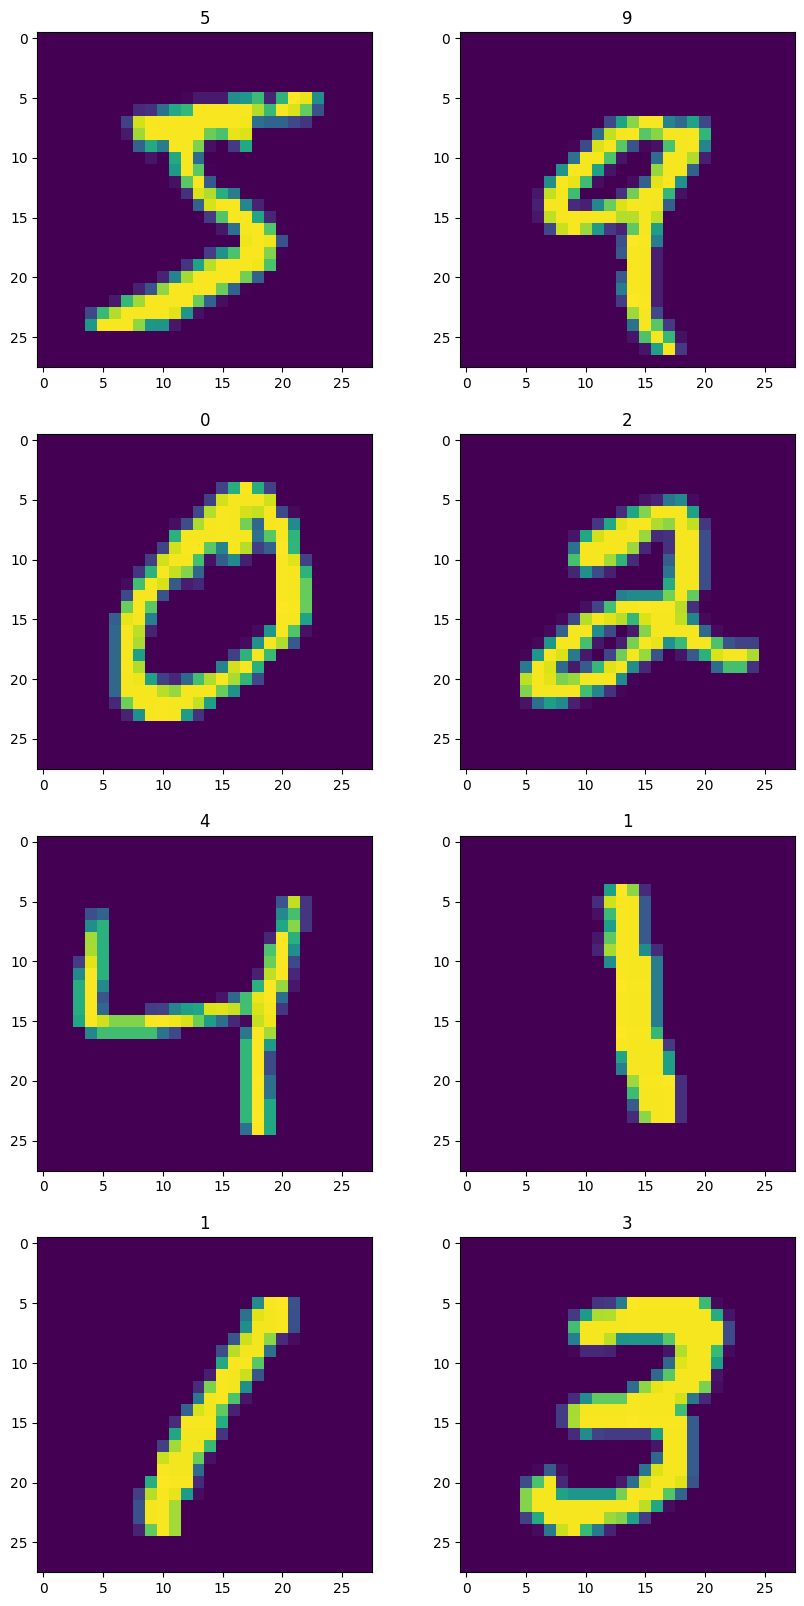

In [5]:
fig, axs = plt.subplots(4, 2, figsize=(10, 20))

for idx, (x, y) in enumerate(mnist_dataset_train):
    ax = axs[idx % 4][idx // 4]
    ax.imshow(x)
    ax.set_title(y)
    if idx == 7:
      break
fig.show()

In [6]:
X_train = np.array([np.array(_[0]).reshape(-1) for _ in mnist_dataset_train])
y_train = np.array([_[1] for _ in mnist_dataset_train])
X_test = np.array([np.array(_[0]).reshape(-1) for _ in mnist_dataset_test])
y_test = np.array([_[1] for _ in mnist_dataset_test])

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train[:2000], y_train[:2000])

LogisticRegression(max_iter=10000)

In [9]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train[:2000], y_train[:2000])

LogisticRegression(max_iter=10000)

In [10]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [11]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'{accuracy_train=}, {accuracy_test=}')

accuracy_train=0.86125, accuracy_test=0.8622


In [12]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm

from IPython.display import clear_output

In [13]:
mnist_dataset_train = MNIST('train', True, download=True, transform=ToTensor())
mnist_dataset_test = MNIST('test', False, download=True, transform=ToTensor())

In [14]:
type(mnist_dataset_test[0][0]), type(mnist_dataset_test[0][1]), mnist_dataset_test[0][0].shape

(torch.Tensor, int, torch.Size([1, 28, 28]))

In [15]:
batch_size = 32
train_dataloader = DataLoader(mnist_dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=False)

In [16]:
for el in train_dataloader:
    print(len(el), el[0].shape, el[1])
    break

2 torch.Size([32, 1, 28, 28]) tensor([1, 6, 0, 3, 8, 9, 9, 0, 7, 4, 0, 8, 4, 5, 6, 0, 5, 1, 7, 2, 7, 0, 7, 8,
        2, 2, 5, 3, 9, 4, 5, 5])


In [17]:
class Mnist(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Conv2d(1, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, 3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(64, 16, 3),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 10)
        )

In [18]:
model = Mnist()
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters())

In [19]:
def train(model, criterion, optimizer, dataloader, max_num_batches=1000):
  total_loss = 0
  total_accuracy = 0
  model.train()
  for idx, batch in tqdm(enumerate(dataloader)):
      optimizer.zero_grad()
      x, y = batch[0], batch[1]
      pred = model(x)
      loss = criterion(pred, y)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      total_accuracy += np.sum(np.argmax(pred.detach().numpy(), axis=1) == y.detach().numpy()) / len(batch[0])
      if idx == max_num_batches:
          break
  return total_loss / max_num_batches, total_accuracy / max_num_batches


In [20]:
def test(model, criterion, optimizer, dataloader):
  total_loss = 0
  total_accuracy = 0
  model.eval()
  with torch.no_grad():
      for idx, batch in tqdm(enumerate(dataloader)):
          x, y = batch[0], batch[1]
          with torch.no_grad():
              pred = model(x)
          loss = criterion(pred, y)
          total_loss += loss.item()
          total_accuracy += np.sum(np.argmax(pred.detach().numpy(), axis=1) == y.detach().numpy()) / len(batch[0])
  return total_loss / len(dataloader), total_accuracy / len(dataloader)

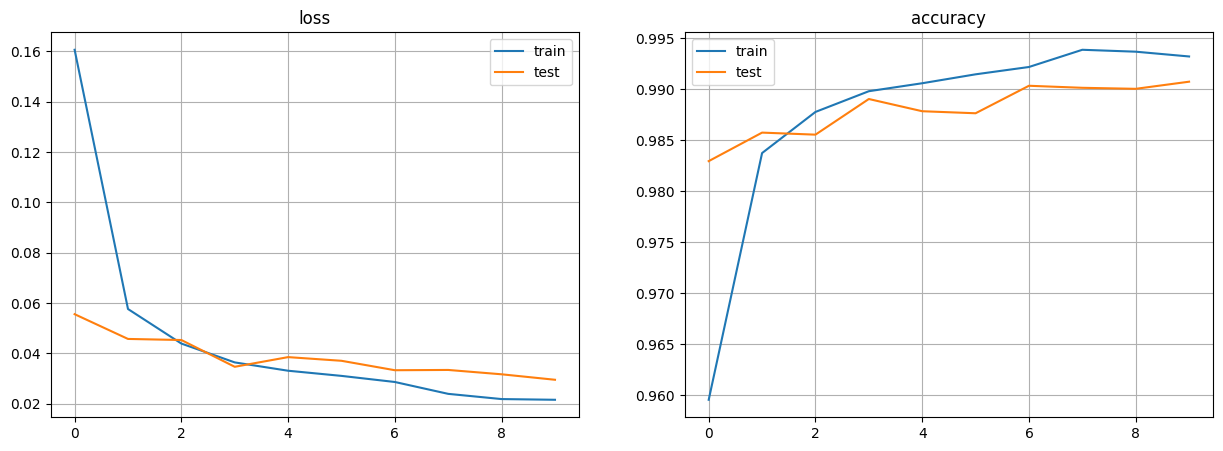

In [21]:
model = Mnist()
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters())

total_train_loss = []
total_test_loss = []
total_train_accuracy = []
total_test_accuracy = []

for epoch in range(10):
    train_loss, train_accuracy = train(model, criterion, optimizer, train_dataloader)
    test_loss, test_accuracy = test(model, criterion, optimizer, test_dataloader)

    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)
    total_train_accuracy.append(train_accuracy)
    total_test_accuracy.append(test_accuracy)

    clear_output(True)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(total_train_loss, label='train')
    axs[0].plot(total_test_loss, label='test')
    axs[0].set_title('loss')
    axs[0].grid()
    axs[0].legend(loc='best')


    axs[1].plot(total_train_accuracy, label='train')
    axs[1].plot(total_test_accuracy, label='test')
    axs[1].set_title('accuracy')
    axs[1].grid()
    axs[1].legend(loc='best')

    plt.show()

In [22]:
print(f"Кол-во параметров: {sum(p.numel() for p in model.parameters())}.")

Кол-во параметров: 22874.
